In [1]:
import json 
import numpy as np
import matplotlib.pyplot as plt
import glob 
from dataclasses import dataclass
import pandas as pd


In [75]:
@dataclass 
class ModelGeneration:
    model_path: str 
    question_num: int
    sample_num: int
    generation: str 
    embedding: list 


def load_generations(file_path):

    with open(file_path, 'r') as f:
        data = json.load(f)

    return ModelGeneration(
        model_path=file_path.split('/')[-2],
        question_num=data['question_id'],
        sample_num=data['sample_index'],
        generation=data['converted_text'],
        embedding=data['converted_embedding']
        # embedding=data['generated_embedding']
    )

model_names = ['taco_instruct_llama_8b_single', 'taco_instruct_llama_8b_single_slerp_0.7', 'taco_instruct_llama_8b_single_slerp_0.90', 'taco_instruct_llama_8b_single_slerp_0.5']
generations = []

for model_name in model_names:
    model_path = f"/scratch/gpfs/vv7118/projects/messi-thinking/embeddings/{model_name}"
    model_files = glob.glob(f"{model_path}/converted_*.json")
    for file_path in model_files:
        try: 
            generations.append(load_generations(file_path))
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")



In [76]:
def calculate_cosine_similarities(df, model_name):
    """Calculate cosine similarities between all rows for a specific model."""
    # Filter for the specific model
    model_df = df[df['model_path'] == model_name].copy()
    
    embeddings = np.array([np.array(emb) for emb in model_df['embedding']])
    similarity_matrix = np.dot(embeddings, embeddings.T)
    sims = similarity_matrix.mean(axis=1)
    model_df['avg_question_similarity'] = sims
    return model_df

In [77]:
def calculate_same_question_similarities(df, model_name):
    """Calculate mean cosine similarities between generations of the same question."""
    model_df = df[df['model_path'] == model_name].copy()
    question_groups = model_df.groupby('question_num')
    
    results = []
    
    for question_num, group in question_groups:
        if len(group) <= 1:
            continue
        embeddings = np.array([np.array(emb) for emb in group['embedding']])
        
        norms = np.linalg.norm(embeddings, axis=1)
        
        normalized_embeddings = embeddings / norms[:, np.newaxis]
        
        similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)
        
        np.fill_diagonal(similarity_matrix, 0)
        
        mean_similarity = similarity_matrix.sum() / (len(group) * (len(group) - 1))
        
        results.append({
            'question_num': question_num,
            'num_samples': len(group),
            'mean_similarity': mean_similarity
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df
    

In [78]:
df = pd.DataFrame(generations)
df = df[df['question_num'] < 500]

In [79]:
df['str_len'] = df['generation'].str.len()
df['str_len_bucket'] = pd.qcut(df['str_len'], q=10, labels=False)

In [80]:
# avg str len diff per qs 
qs = df.groupby(['model_path', 'question_num'])['str_len'].mean().reset_index()
qs = qs.pivot(index='question_num', columns='model_path', values='str_len')
qs['diff'] = qs['taco_instruct_llama_8b_single'] - qs['taco_instruct_llama_8b_single_slerp_0.7']
qs['diff_0.90'] = qs['taco_instruct_llama_8b_single'] - qs['taco_instruct_llama_8b_single_slerp_0.90']
print(qs['diff'].mean())
print(qs['diff_0.90'].mean())


4742.828
8906.513666666668


In [56]:
qs_to_limit_to = qs[qs['diff'].abs() < 500].index.tolist()

In [57]:
df_temp = df[df['question_num'].isin(qs_to_limit_to)]


In [81]:
df1 = calculate_cosine_similarities(df, 'taco_instruct_llama_8b_single')
df2 = calculate_cosine_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.7')
df3 = calculate_cosine_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.90')
df4 = calculate_cosine_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.5')


In [82]:
pd.concat([df1, df2, df3, df4], axis=0).groupby(['model_path'])['avg_question_similarity'].mean()


model_path
taco_instruct_llama_8b_single               0.528267
taco_instruct_llama_8b_single_slerp_0.5     0.469808
taco_instruct_llama_8b_single_slerp_0.7     0.492696
taco_instruct_llama_8b_single_slerp_0.90    0.489987
Name: avg_question_similarity, dtype: float64

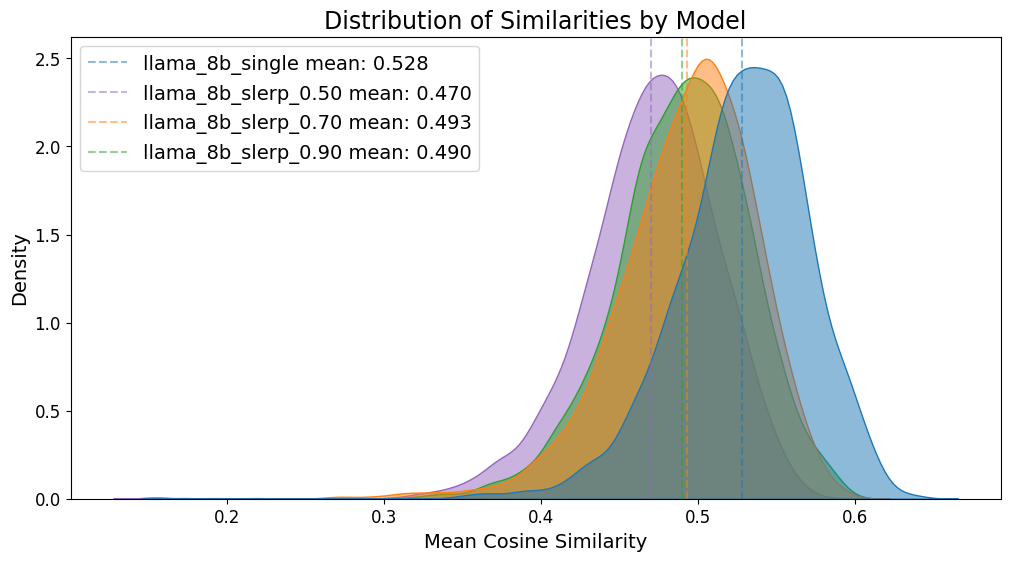

In [94]:
import seaborn as sns
model_colors = {
    'llama_8b_single': '#1f77b4',  # blue
    'llama_8b_slerp_0.50': '#9467bd',  # purple
    'llama_8b_slerp_0.70': '#ff7f0e',  # orange
    'llama_8b_slerp_0.90': '#2ca02c',  # green
}

plot_data = pd.concat([
    pd.DataFrame({
        'similarity': df1['avg_question_similarity'],
        'model': 'llama_8b_single'
    }),
    pd.DataFrame({
        'similarity': df2['avg_question_similarity'],
        'model': 'llama_8b_slerp_0.70'
    }),
    pd.DataFrame({
        'similarity': df3['avg_question_similarity'],
        'model': 'llama_8b_slerp_0.90'
    }),
    pd.DataFrame({
        'similarity': df4['avg_question_similarity'],
        'model': 'llama_8b_slerp_0.50'
    })
])

# Create the plot
plt.figure(figsize=(12, 6))
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=True, alpha=0.5, palette=model_colors)
plt.title('Distribution of Similarities by Model', fontsize=17)
plt.xlabel('Mean Cosine Similarity', fontsize=14)
plt.ylabel('Density', fontsize=14)

for model, color in model_colors.items():
    if model == 'llama_8b_single':
        mean = df1['avg_question_similarity'].mean()
    elif model == 'llama_8b_slerp_0.70':
        mean = df2['avg_question_similarity'].mean()
    elif model == 'llama_8b_slerp_0.90':
        mean = df3['avg_question_similarity'].mean()
    elif model == 'llama_8b_slerp_0.50':
        mean = df4['avg_question_similarity'].mean()
    
    plt.axvline(mean, color=color, linestyle='--', alpha=0.5,
               label=f'{model} mean: {mean:.3f}')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)    

plt.legend(fontsize=14)
plt.savefig('avg_question_similarity.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [84]:
pd.concat([df1, df2], axis=0).groupby(['model_path', 'str_len_bucket'])['avg_question_similarity'].mean()


model_path                               str_len_bucket
taco_instruct_llama_8b_single            0                 0.406357
                                         1                 0.474697
                                         2                 0.512632
                                         3                 0.525042
                                         4                 0.528504
                                         5                 0.530896
                                         6                 0.534405
                                         7                 0.528180
                                         8                 0.530226
                                         9                 0.527806
taco_instruct_llama_8b_single_slerp_0.7  0                 0.426677
                                         1                 0.472203
                                         2                 0.489616
                                         3                 0

In [86]:
m1 = calculate_same_question_similarities(df, 'taco_instruct_llama_8b_single')
m2 =calculate_same_question_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.7')
m3 = calculate_same_question_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.90')
m4 = calculate_same_question_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.5')

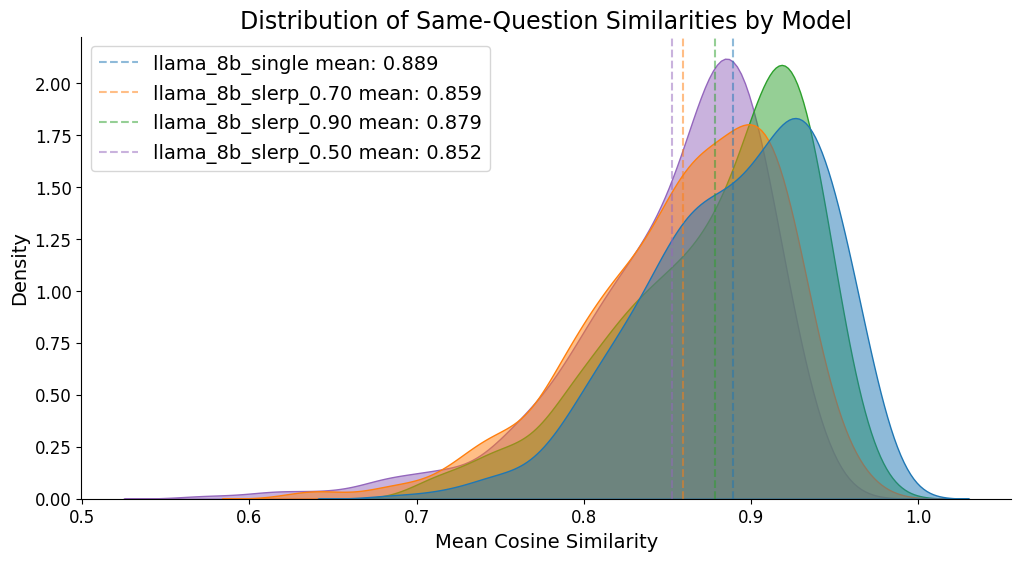

In [95]:
import seaborn as sns
plot_data = pd.concat([
    pd.DataFrame({
        'similarity': m1['mean_similarity'],
        'model': 'llama_8b_single'
    }),
    pd.DataFrame({
        'similarity': m2['mean_similarity'],
        'model': 'llama_8b_slerp_0.70'
    }),
    pd.DataFrame({
        'similarity': m3['mean_similarity'],
        'model': 'llama_8b_slerp_0.90'
    }),
    pd.DataFrame({
        'similarity': m4['mean_similarity'],
        'model': 'llama_8b_slerp_0.50'
    })
])

# Create the plot
plt.figure(figsize=(12, 6))
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=True, alpha=0.5, palette=model_colors)
plt.title('Distribution of Same-Question Similarities by Model', fontsize=17)
plt.xlabel('Mean Cosine Similarity', fontsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.ylabel('Density', fontsize=14)
model_means = {
    'llama_8b_single': m1['mean_similarity'].mean(),
    'llama_8b_slerp_0.70': m2['mean_similarity'].mean(),
    'llama_8b_slerp_0.90': m3['mean_similarity'].mean(),
    'llama_8b_slerp_0.50': m4['mean_similarity'].mean()
}
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


for model, mean in model_means.items():
    plt.axvline(mean, color=model_colors[model], linestyle='--', alpha=0.5,
               label=f'{model} mean: {mean:.3f}')
plt.legend(fontsize=14)
plt.savefig('avg_same_question_similarity.pdf', dpi=300, bbox_inches='tight')

plt.show()

